# Set up

### Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import librosa
import matplotlib.pyplot as plt    
import numpy as np
import pandas as pd 
import seaborn as sns

#import librosa.display
#import matplotlib   
#import IPython.display as ipd
#from scipy.io import wavfile

from scipy import signal
from scipy.stats import norm, kurtosis
from scipy.signal import welch
from scipy.integrate import simps

#import scipy 

import operator #Used to sort 
import glob #
import json
from datetime import datetime

##import warnings
##warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
import statistics

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [3]:
df_paths = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/wav_paths_master.csv") 
df_paths['mic'] = df_paths['mic'].str.replace("l", "").str.replace("m", "").apply(pd.to_numeric) #Removes 'm' and 'l' from mic and casts it to int 



# Functions

## Helper functions 

In [4]:
def join_meta(df_meta, df_input):
  df = df_input.join(df_meta)
  df.index.name = "index"
  return df

In [5]:

def pre_save_files(df_input, save_path=None, sr=None):
  df_files = pd.DataFrame()

  for ind in tqdm(df_input.index):
    y, sample_rate = librosa.load(df_input['path'][ind], sr=None)
    df_file = pd.DataFrame({"samples": [y], "sr": sample_rate})
    df_files = pd.concat([df_files, df_file], join = 'outer', axis = 0)
  df_files.index = df_input.index
  
  if save_path:
    df_files.to_json(save_path)


  return df_files



In [6]:
def preprocesses(X,T,normalize=True):
  if normalize:
    scaler = MinMaxScaler()
    scaler = scaler.fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X))
    X_scaled.columns = X.columns
    T_scaled = pd.DataFrame(scaler.transform(T))
    T_scaled.columns = T.columns

  return X_scaled, T_scaled 


In [7]:
def make_list(split_list): #[0,10000,1000]
  split = split_list.copy()
  split[1] = split[1]+split[-1]
  splitted_list =  np.arange(split[0], split[1], split[2]).tolist()
  return splitted_list

In [8]:
def invert_preds(preds):
  return np.abs(preds-1)

def get_accuracy(pred, gt):
  score = 0 
  if len(pred) != len(gt):
    return
  for i in range(len(pred)):
    if pred[i] == gt[i]:
      score+=1

  accuracy = np.round(score/len(pred),4)

  if accuracy < 0.1:
    accuracy=1-accuracy

  return accuracy

In [9]:
def get_wanted_files(df, wanted_files):
    for key in wanted_files:
        if wanted_files[key]:
            df = df.loc[(df[key].isin(wanted_files[key]))]
    return df 


In [10]:
def bandpower(data, sf, band_list, window_sec=None, relative=False, reduce_split=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """


    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = 0.3 * sf

    # Compute the modified periodogram (Welch)
    #win = scipy.signal.get_window('hanning',nperseg)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    
    avg_band_power = []

    #Kan vurdere å bruke matplotlib sin psd 
    ##win = matplotlib.mlab.window_hanning(np.ones(nperseg)) # or
    ##psd, freqs = matplotlib.mlab.psd(data, Fs=sf,window=win)



    # Frequency resolution
    for i in range(len(band_list)-1):
      freq_res = freqs[1] - freqs[0]
      low = band_list[i]
      high = band_list[i+1]

      # Find closest indices of band in frequency vector
      idx_band = np.logical_and(freqs >= low, freqs <= high)

      # Integral approximation of the spectrum using Simpson's rule.
      bp = simps(psd[idx_band], dx=freq_res)


      if relative:
          bp /= simps(psd, dx=freq_res)

      
      avg_band_power.append(bp)


    if reduce_split:
      reduced = []  
      for i in range(len(reduce_split)-1):
        s = avg_band_power[reduce_split[i]:reduce_split[i+1]]
        reduced.append(sum(s))
      return pd.DataFrame([reduced])

    return pd.DataFrame([avg_band_power])

In [11]:
def plot_learning_curve(estimator, title, X, y,cv=None, n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 5),):
  plt.figure(figsize=(8,5))
  train_sizes, train_scores, test_scores = learning_curve(estimator,X,y)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",)
  plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")


  plt.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g",)
  plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

  plt.legend(loc="best")
  plt.title(title)
  plt.show()

In [12]:
def plot_corr_matrix(df_features):
  # run correlation matrix and plot
  f, ax = plt.subplots(figsize=(10, 8))
  corr = df_features.corr()
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
              cmap=sns.diverging_palette(220, 10, as_cmap=True),
              square=True, ax=ax)

## Feature functions

In [13]:
#Kan hende denne kan slettes? 
def get_bandpower_dataframe(df_input,window_sec, split_list, reduce_split=False):
  df = pd.DataFrame()

  band_list = make_list(split_list)
  
  for ind in tqdm(df_input.index):
    signal, sr = np.array(df_input["samples"][ind]), df_input["sr"][ind]
    bin_power = bandpower(signal, sr, band_list ,window_sec=window_sec, relative=True, reduce_split=reduce_split)
    df = pd.concat([df,bin_power],axis=0,ignore_index=True)
  
  df.index = df_input.index
  names = [str("rp_bin: " + str(i)) for i in range(len(np.array(df.columns)))]
  df.columns = names

  return df

"""
Split_list is what frequency segements the file should be devidied into, while reduce split combines several segments by summing between the elements in the list
A unneccesery way of doing it but I like that I still can get the firste version without reduced split
"""
#df_rel_pwr_train = get_bandpower_dataframe(df_train.head(), window_sec=10, split_list=[0, 24000, 1000])
#df_rel_pwr_train = get_bandpower_dataframe(df_train.head(), window_sec=10, split_list=[0, 24000, 1000], reduce_split=[0,6,13,-1])
#df_rel_pwr_train


'\nSplit_list is what frequency segements the file should be devidied into, while reduce split combines several segments by summing between the elements in the list\nA unneccesery way of doing it but I like that I still can get the firste version without reduced split\n'

In [14]:
def get_data_labels(df_train_features, df_test_features, drop_features=None):

  df_train_features_drop = df_train_features.drop(columns=['feature_index', 'index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')
  df_test_features_drop = df_test_features.drop(columns=['feature_index','index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')


  y = df_train_features_drop['leak_present'].values
  X = df_train_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    X = X.drop(columns=drop_features)

  gt = df_test_features_drop['leak_present'].values
  T = df_test_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    T = T.drop(columns=drop_features)



  return X,y,T,gt


## Feature Extraction

In [15]:
def get_train_test_dataframes_presaved(df, train_files, test_files, verbose):    
    df_train = get_wanted_files(df, train_files)
    df_test = get_wanted_files(df, test_files)

    if verbose: 
        print(str(np.round(df_train["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_train["leak_present"].value_counts())
        print(str(np.round(df_test["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_test["leak_present"].value_counts())
        
    return df_train, df_test


In [16]:
def get_train_test_dataframes(df, train_files, test_files, verbose):    
    df_train = get_wanted_files(df, train_files)
    df_test = get_wanted_files(df, test_files)

    df_train_loaded = pre_save_files(df_train)
    df_test_loaded = pre_save_files(df_test)

    df_train = join_meta(df_train_loaded, df_train)
    df_test = join_meta(df_test_loaded, df_test)

    if verbose: 
        print(str(np.round(df_train["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_train["leak_present"].value_counts())
        print(str(np.round(df_test["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_test["leak_present"].value_counts())
        
    return df_train, df_test



In [17]:
def get_train_test_features(df_train, df_test, use_features, split_list, win_len, log_rel_pwr, shuffle):

  print("> making train features")
  df_train_features = get_all_features(df_train, use_features, split_list, win_len,log_rel_pwr=False) 
  df_train_features = df_train_features.loc[:, ~df_train_features.columns.duplicated()]
  df_train_features = df_train_features.join(df_train, on="feature_index", how="left")
  print("")

  
  print("> making test features")
  df_test_features = get_all_features(df_test,use_features, split_list, win_len,log_rel_pwr=False) 
  df_test_features = df_test_features.loc[:, ~df_test_features.columns.duplicated()]
  df_test_features = df_test_features.join(df_test, on="feature_index",how="left")
  print("")




  if log_rel_pwr:
    #x_norm, t_norm = preprocesses(df_train_features.filter(regex='rp_bin'), df_test_features.filter(regex='rp_bin'))
    x_norm, t_norm = df_train_features.filter(regex='rp_bin'), df_test_features.filter(regex='rp_bin')

    x_norm_log = np.log(x_norm) #Can test log10, log2 as well
    t_norm_log = np.log(t_norm)    
    df_train_features.loc[x_norm_log.index.isin(df_train_features.index), x_norm_log.columns.values] = x_norm_log[x_norm_log.columns.values]
    df_test_features.loc[t_norm_log.index.isin(df_test_features.index), t_norm_log.columns.values] = t_norm_log[t_norm_log.columns.values]

  if shuffle: 
    df_train_features = shuffle(df_train_features)
    df_test_features = shuffle(df_test_features)


  return df_train_features, df_test_features


In [18]:
def get_all_features(df, use_features, split_list, win_len=0.3, log_rel_pwr=False):

  if "time-freq" in use_features: 
    print("time-frequency features")
    df_freq = get_time_freq_feature_dataframe(df, win_len=win_len)
  else: 
    df_freq = pd.DataFrame()

  if "rel-pwr" in use_features: 
    print("relative power features")
    #df_relative_pwr = get_bandpower_dataframe(df, window_sec=10, split_list=[0, 24000, 2500])
    df_relative_pwr = get_bandpower_dataframe_framed(df,win_len=win_len, window_sec=1, split_list=split_list)
    #df_relative_pwr = get_bandpower_dataframe(df, window_sec=10, split_list=[0, 24000, 1000], reduce_split=[0,6,13,-1]) #This reduce split means: from 0-6kHz, 6-13kHz, and 13kHz to the end
    #if log_rel_pwr: 
    #  df_relative_pwr = np.log10(df_relative_pwr)
    print("done!")
  else: 
    df_relative_pwr = pd.DataFrame()



  #df_all_features = df_freq.join(df_relative_pwr, on="index")
  df_freq.reset_index(inplace=True)
  df_relative_pwr.reset_index(inplace=True)
  
  df_all_features = pd.concat([df_freq,df_relative_pwr],axis=1)

  df_all_features.columns = df_all_features.columns.astype(str)

  #df_all_features.index = df
  return df_all_features 
  

In [19]:
def get_time_freq_feature_dataframe(df_input, win_len):

  features = []

  for ind in tqdm(df_input.index):
    #feature_list = freq_domain_features(np.array(df_input["samples"][ind]), df_input["sr"][ind], ind, win_len=win_len)

    feature_list_time = time_domain_features(df_input["samples"][ind],df_input["sr"][ind], win_len=win_len, return_empty=False)
    feature_list_freq = freq_domain_features(df_input["samples"][ind],df_input["sr"][ind], ind, win_len=win_len)

    feature_list = pd.concat([feature_list_time, feature_list_freq], join = 'outer', axis = 1)
    features.append(feature_list)

  df = pd.concat(features, ignore_index=True)


  return df


In [20]:
def time_domain_features(signal, sr, win_len, return_empty=False):

  if return_empty:
    return pd.DataFrame()
    
  mean = []
  max = []
  std = []
  kurt = []
  skew = []
  #rms = []
  crest_factor = []
  PPV = []


  FRAME_LENGTH = int(sr * win_len)
  HOP_LENGTH = FRAME_LENGTH//2

  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%
  #print(frames.shape)
  for frame in frames: 
    mean.append(np.mean(frame))
    max.append(np.max(np.abs(frame)))
    std.append(np.std(frame))
    
    #rms.append(compute_rms(frame))
    #crest_factor.append(np.max(np.abs(frame)) / compute_rms(frame))



  features = [mean, std, max]
  names = ["mean", "std", "max"]


  dft = pd.DataFrame(features).T

  dft.columns = names
  return dft


In [21]:
from scipy.stats import kurtosis, skew

def freq_domain_features(signal, sr, index, win_len=1, no_panda=False,):
  peak_freq = []
  peak_freq_amp = []

  FRAME_LENGTH = int(sr * win_len)
  HOP_LENGTH = FRAME_LENGTH//2
  
  
  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%


  #for frame in frames: 
  #  peak_freq.append((n_max_freq_amp(1,frame, sr)[0])[0])
  #  peak_freq_amp.append((n_max_freq_amp(1,frame, sr)[1])[0])

  #RETURNS 2D FEATURE LIST 
  #spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0]).T
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False))#.mean(axis=0)  
  df_contrast = pd.DataFrame(spec_contrast).T
  names_contrast = [str("cont_bin: " + str(i)) for i in range(len(np.array(df_contrast.columns)))]
  df_contrast.columns = names_contrast
  
  #RETURNS 1D FEAUTRE LIST 
  spec_centroid = (librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_bandwidth = (librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_flatness = (librosa.feature.spectral_flatness(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  #spec_rolloff = (librosa.feature.spectral_rolloff(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  #S, phase = librosa.magphase(librosa.stft(signal,n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False))
  #spec_rms = (librosa.feature.rms(S=S, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False)[0]).T

  flat_features = [spec_centroid, spec_bandwidth, spec_flatness] 
  flat_names = ["spec_centroid", "spec_bandwidth", "spec_flatness"]


  index_col = (np.ones(len(frames))*index)
  flat_features += [index_col]
  flat_names += ["feature_index"]

  df_flat = pd.DataFrame(flat_features).T
  df_flat.columns = flat_names 

  df = pd.concat([df_contrast,df_flat],axis=1)

  return df

In [22]:

def get_bandpower_dataframe_framed(df_input, win_len, window_sec, split_list, reduce_split=False):
  df = pd.DataFrame()


  #band_list = make_list(split_list)
  band_list = [0,10000,20000,24000]

  #for ind in tqdm(df_input.index):
  for ind in (df_input.index):

    df_signal = pd.DataFrame()

    signal, sr = np.array(df_input["samples"][ind]), df_input["sr"][ind]

    #win_len = librosa.get_duration(y=signal, sr=sr)//2
    FRAME_LENGTH = int(sr * win_len)
    HOP_LENGTH = FRAME_LENGTH//2
    frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%
    
    for frame in frames:
      bin_power = bandpower(frame, sr, band_list ,window_sec=window_sec, relative=True, reduce_split=reduce_split)
      bin_power['index'] = [float(ind)]
      
      df_signal = pd.concat([df_signal,bin_power],axis=0)
    
    df = pd.concat([df,df_signal],axis=0,)

  names = [str("rp_bin: " + str(i)) for i in range(len(np.array(df.columns)))]
  df.columns = names
  df.columns = [*df.columns[:-1], 'feature_index']

  return df

#get_bandpower_dataframe_framed(df.head(5), win_len=10, window_sec=1, split_list=[0, 24000, 2500])

## ML functions

In [23]:
def plot_model_learning_curves(trained_models, train_data, labels):
  for model in trained_models:
    plot_learning_curve(trained_models[model], model, train_data, labels )
  return 

def plot_feature_importance(trained_models,train_data):
      features = train_data.columns
      for model in trained_models:
        try: 
          tree_feature_importances = trained_models[model].feature_importances_
          indices = np.argsort(tree_feature_importances)
          plt.figure(figsize=(15,10)) 
          plt.title(model + ' Feature Importances')
          plt.barh(range(len(indices)), tree_feature_importances[indices], align='center')
          plt.yticks(range(len(indices)), [features[i] for i in indices])
          plt.xlabel('Relative Importance')
        except:
          plt.close()
        #plt.show()

def plot_decsion_tree(trained_models, train_data):
  fn = train_data.columns.values
  cn=['no_leak', 'leak']
  model = "dt"
  #Text tree representation
  print("Text representation of decision tree: ")
  print("")
  print(tree.export_text(trained_models[model],decimals=4))
  print("")

  #Plot three representation
  fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=150)
  tree.plot_tree(trained_models[model],
                feature_names = fn, 
                class_names=cn,
                precision=4,
                filled = True)
  plt.title("Visual representation of decision tree")
  plt.show()

def plot_confusion_matricies(trained_models, test_data, test_label):
  for model in trained_models:
      try:
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title(model + " confusion matrix")
        disp = ConfusionMatrixDisplay.from_estimator(
            trained_models[model],
            test_data,
            test_label,
            display_labels=[0,1],
            cmap=plt.cm.Blues,
            normalize=None,
            ax=ax) 
      except:
        plt.close()

In [24]:
def plot_model_information(trained_models,train_data,train_labels, test_data, test_labels, tree_plot, learning_curves, feature_importance, confusion_matrix):
  if tree_plot:
    plot_decsion_tree(trained_models, train_data)
  if learning_curves:
    plot_model_learning_curves(trained_models,train_data,train_labels)
  if feature_importance:
    plot_feature_importance(trained_models,train_data)
  if confusion_matrix:
    plot_confusion_matricies(trained_models, test_data,test_labels)



In [25]:
def store_files_and_score(scores, train_files, test_files,features, save_path):
  now = datetime.now()
  dt_string = now.strftime("%d/%m/%Y %H:%M:%S") #Setting the key to current time 

  one_run = {
      dt_string : {
        "scores":scores,
        "train_files":train_files,
        "test_files":test_files,
        "features":features,
        }
      }

  if save_path:
    try: 
      with open(save_path, "r+") as file: #If file excists we append the results
        data = json.load(file)
        data.update(one_run)
        file.seek(0)
        json.dump(data, file,indent=5)
    except: #Has to create the file if it does not excist 
      with open(save_path, "w") as file:
        json.dump(one_run, file,indent=5)

  else: 
    return 

In [26]:
def read_run_plan(run_plan_path):
  with open(run_plan_path, 'r') as f:
    return json.load(f)


In [27]:
def run_several_tests_recording_split(df_paths, run_plan, save_path, print_scores=True):
    prev_train_files = None
    prev_test_files = None
    prev_features = None
    prev_df_train = None
    prev_df_test = None 

    for run in run_plan:
        print("working on run: " + str(run))
        train_files = run_plan[run]["train_files"] #Important that these names are used in the run_plan file 
        test_files = run_plan[run]["test_files"]
        features = run_plan[run]["features"]

        if train_files == prev_train_files and test_files == prev_test_files: #If they are the same as before we don't create them again
          print("these are the same as last run, so reuse them")
          df_train, df_test = prev_df_train, prev_df_test
        else: 
          print("not the same as last run, create new")
          df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, verbose=False)

        df_train_features, df_test_features = get_train_test_features(df_train, df_test, split_list = features['split_list'], win_len=features['win_len'], log_rel_pwr=features['log_rel_pwr'], shuffle=features['shuffle'])
        
        stored_scores = train_test_with_record_split(df_train_features, df_test_features)
        
        #X, y, T, gt = get_data_labels(df_train_features, df_test_features)

        #trained_models = train_ml_models(X,y)
        #scores = predict_ml_models(trained_models,T,gt)
        
        if print_scores: 
          print(scores)
          print("----")

        store_files_and_score(stored_scores, train_files, test_files,features, save_path = save_path)
        
        prev_df_train, prev_df_test = df_train, df_test
        prev_train_files, prev_test_files = train_files, test_files

    return

In [28]:
def run_several_tests(df_paths, run_plan, save_path, print_scores=True):
    prev_train_files = None
    prev_test_files = None
    prev_features = None
    prev_df_train = None
    prev_df_test = None 

    for run in run_plan:
        print("working on run: " + str(run))
        train_files = run_plan[run]["train_files"] #Important that these names are used in the run_plan file 
        test_files = run_plan[run]["test_files"]
        features = run_plan[run]["features"]

        if train_files == prev_train_files and test_files == prev_test_files: #If they are the same as before we don't create them again
          print("these are the same as last run, so reuse them")
          df_train, df_test = prev_df_train, prev_df_test
        else: 
          print("not the same as last run, create new")
          df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, verbose=False)

        df_train_features, df_test_features = get_train_test_features(df_train, df_test, win_len=features['win_len'], log_rel_pwr=features['log_rel_pwr'], shuffle=features['shuffle'])
        X, y, T, gt = get_data_labels(df_train_features, df_test_features)

        trained_models = train_ml_models(X,y)
        scores = predict_ml_models(trained_models,T,gt)
        
        if print_scores: 
          print(scores)
          print("----")

        store_files_and_score(scores, train_files, test_files,features, save_path = "stored_files_and_score.json")
        
        prev_df_train, prev_df_test = df_train, df_test
        prev_train_files, prev_test_files = train_files, test_files

    return

In [29]:
def get_classification_report(trained_models, test_data, test_labels):
  for model in trained_models: 
    preds = trained_models[model].predict(test_data)
    print("Model name: " + model.upper())
    print(classification_report(test_labels, preds))



In [30]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def predict_ml_models(trained_models, data, labels):
    scores = {}
    true_pred_sums = {}
    f1_scores = {}
    recalls = {}
    precisions = {}



    for model in trained_models:
        predictions = trained_models[model].predict(data) 
        score = trained_models[model].score(data,labels) 
        true_preds = np.sum(predictions)/len(predictions)
        f1 = f1_score(labels, predictions, average='macro')
        recall = recall_score(labels, predictions)
        precision = precision_score(labels, predictions)

        if model == "km": #Kmeans has no score method 
          score = get_accuracy(trained_models[model].predict(data), labels)
        scores[model] = score
        true_pred_sums[model] = true_preds
        f1_scores[model] = f1
        recalls[model] = recall
        precisions[model] = precision



        


    sorted_scores = dict(sorted(scores.items(), key=operator.itemgetter(1),reverse=True))

    return sorted_scores, true_pred_sums, f1_scores, recalls, precisions 

In [31]:
def train_test_recordwise(df_train_features, df_test_features):
  recs_train = df_train_features.recording.unique()
  recs_test = df_test_features.recording.unique()
  if (recs_train != recs_test).all(): 
    print("No")
    return None
    
  dfs = []
  for rec in recs_test: 
    df_test_features_rec = df_test_features.loc[df_test_features['recording'] == rec] 
    df_train_features_rec = df_train_features.loc[df_train_features['recording'] != rec] 
    dfs.append([df_train_features_rec,df_test_features_rec])
  
  return dfs

def train_test_with_record_split(df_train_features, df_test_features,normalize,reduced_features):

  record_splitted_dfs = train_test_recordwise(df_train_features, df_test_features)
  score_storage = []
  for record_split in record_splitted_dfs:
    X, y, T, gt = get_data_labels(pd.DataFrame(record_split[0]),pd.DataFrame(record_split[1]),drop_features=None)
    if reduced_features: 
      top_10_features = ['rp_bin: 5','rp_bin: 1','spec_bandwidth','rp_bin: 3','rp_bin: 6','rp_bin: 0','rp_bin: 2','spec_flatness','rp_bin: 9','rp_bin: 8']
      X = X[top_10_features]
      T = T[top_10_features]
    if normalize:
      X,T = preprocesses(X,T)
    trained_models = train_ml_models(X,y)
    scores = predict_ml_models(trained_models,T,gt)[0]
    score_storage.append(scores)
  
  average = pd.DataFrame(score_storage).mean()

  return average
  #print(">>>>>> SCORES: ", scores)  

# Run code

In [32]:
df_train_features = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_OC_m4alleaksenvs")

In [33]:
df_train_features.environment.unique()

array(['hydr', 'lab', 'work', 'hydr_low', 'work_low'], dtype=object)

In [2]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

models = {
  #"oc-svm_nu=0.01": OneClassSVM(gamma='scale',nu=0.01),
  "oc-svm_nu=0.1": OneClassSVM(gamma='scale',nu=0.1),
  #"oc-svm_nu=0.2": OneClassSVM(gamma='scale',nu=0.2),
  #"oc-svm_nu=0.5": OneClassSVM(gamma='scale',nu=0.5),
  #"oc-svm_auto": OneClassSVM(gamma='scale'),


  "lof_auto" : LocalOutlierFactor(novelty=True, contamination="auto"),
  #"lof_con=0.1" : LocalOutlierFactor(novelty=True, contamination=0.1),
  #"lof_0.01" : LocalOutlierFactor(novelty=True, contamination=0.01),
  #"lof_0.2" : LocalOutlierFactor(novelty=True, contamination=0.2),

  #"if10": IsolationForest(n_estimators=10, warm_start=False),
  #"if20": IsolationForest(n_estimators=20, warm_start=False),
  #"if50": IsolationForest(n_estimators=50, warm_start=False),
  #"if_boot": IsolationForest(warm_start=False,bootstrap=True),
  "if_default": IsolationForest(warm_start=False),
  #"if_con=0.1": IsolationForest(n_estimators=100, warm_start=False, contamination=0.1),
}

In [3]:
for model in models:
  print(model)
  print(models[model].get_params())
  print("---")

oc-svm_nu=0.1
{'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
---
lof_auto
{'algorithm': 'auto', 'contamination': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 20, 'novelty': True, 'p': 2}
---
if_default
{'bootstrap': False, 'contamination': 'auto', 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}
---


In [ ]:
X = df_train_features

exploring_env = ["hydr", "hydr"]
exploring_env = ["work", "work"]
exploring_env = ["hydr", "hydr_low"]
exploring_env = ["work", "work_low"]

exploring_env = ["lab", "lab"]

X = X[X['environment'].isin(exploring_env)] #Only looking at for instance work/work_low
y = X.leak_present.values

cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values


features_top_1 = ["spec_bandwidth","rp_bin: 5"]
features_top_2 = ["mfcc_bin: 5","rp_bin: 5"]
features_top_3 = ["mfcc_bin: 5","rp_bin: 5","mfcc_bin: 4", "rp_bin: 4", "spec_bandwidth", "spec_centroid", "cont_bin: 6"]

sub_features = features_top_1

all_results = {}
for model in models: 
  print("Model: ", model)
  results = {}
  for train_idxs, test_idxs in cv.split(X,y,env_groups):
    #print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
    #print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))
    

    X_train_features = X.iloc[train_idxs].loc[(X.iloc[train_idxs].leak_present == 0)] #Train data is only negative labels  
    X_test_features = X.iloc[test_idxs] #Test features is all 


    #If we want to split train and test further:
    X_train_features = X_train_features[X_train_features['environment'] == exploring_env[0]]
    X_test_features = X_test_features[X_test_features['environment'] == exploring_env[1]]

    #Used for plotting later
    X_train_features_lp = X_train_features["leak_present"]
    X_test_features_lp = X_test_features["leak_present"]
    
    #Getting only relevant features and splitting data and labels
    X_train, y_train, X_test, y_test = get_data_labels(X_train_features, X_test_features)
    #Normalizing the data 
    X_train, X_test = preprocesses(X_train, X_test)

    if sub_features: 
      X_train = X_train[sub_features]
      X_test = X_test[sub_features]

    X_train_features_lp.reset_index(drop=True, inplace=True)
    X_train_info = pd.concat([X_train, X_train_features_lp], axis=1)
    
    #LOF needs different input from the rest 
    if "lof" in model:
      models[model].fit(X_train.values) 
    else:
      models[model].fit(X_train) 

    #Converting the predictions to the same format as in training data 
    preds = models[model].predict(X_test)
    preds = [1 if i==-1 else 0 for i in preds]


    pred_col = pd.DataFrame(preds)
    pred_col.columns = ["preds"]
    pred_col.reset_index(drop=True, inplace=True)
    X_test_features.reset_index(drop=True, inplace=True)
    X_test_info_preds = pd.concat([X_test_features, pred_col["preds"]], axis=1)
    x_test_preds = X_test_info_preds

    #Also used for plotting 
    X_test_features_lp.reset_index(drop=True, inplace=True)
    X_test_info = pd.concat([X_test, X_test_features_lp], axis=1)
    
    #Can print classification report for each split
    #print(classification_report(y_test, preds))

    for leak in x_test_preds.leak_type.unique():
        #print(leak, env)
        preds = x_test_preds.loc[(x_test_preds.leak_type == leak)]["preds"]
        y_test = x_test_preds.loc[(x_test_preds.leak_type == leak)]["leak_present"]
        f1 = f1_score(preds, y_test)
        acc = accuracy_score(preds, y_test)
        #print(leak, env)
        #print(f1)
        key = str(leak)
        metric = f1
        if key in results:
          results[key].append(metric)
        else:
          results[key] = [metric]
  average_results = {}
  for key, vals in results.items():
    if (0.0 in vals) or (0 in vals):
      vals.remove(0)
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
    else: 
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]


    all_results[model] = average_results
all_results

Model:  oc-svm_nu=0.1
Model:  lof_auto
Model:  if_default


{'if_default': {'tubeleak': [92.23922797959308, 1.3230306822859177],
  'ventleak': [95.86275919253788, 1.744839982433484],
  'ventlow': [88.85500048690234, 2.229543584981524]},
 'lof_auto': {'tubeleak': [94.93101935054312, 1.7608374731573686],
  'ventleak': [95.51588993806477, 1.7877582569721158],
  'ventlow': [90.76857342532425, 3.4988116781158998]},
 'oc-svm_nu=0.1': {'tubeleak': [90.98347449416679, 1.3257159948065256],
  'ventleak': [95.77251670274927, 1.4120760893667559],
  'ventlow': [90.12733685247966, 3.6391861958582217]}}

In [35]:
X = df_train_features

envs = [["lab", "lab"],["hydr", "hydr"],["work", "work"],["hydr", "hydr_low"],["work", "work_low"]]

all_results_Novelty = {}
for env in envs: 
  X = df_train_features

  print("Train: ", env[0])
  print("Test: ", env[1])
  
  X = X[X['environment'].isin(env)] #Only looking at for instance work/work_low
  y = X.leak_present.values

  cv = StratifiedGroupKFold(n_splits=3)
  env_groups = X.recording.values

  features_top_1 = ["spec_bandwidth","rp_bin: 5"]
  features_top_2 = ["mfcc_bin: 5","rp_bin: 5"]
  features_top_3 = ["mfcc_bin: 5","rp_bin: 5","mfcc_bin: 4", "rp_bin: 4", "spec_bandwidth", "spec_centroid", "cont_bin: 6"]

  sub_features = features_top_3

  all_results = {}
  for model in models: 
    results = {}
    for train_idxs, test_idxs in cv.split(X,y,env_groups):
      #print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
      #print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))
      

      X_train_features = X.iloc[train_idxs].loc[(X.iloc[train_idxs].leak_present == 0)] #Train data is only negative labels  
      X_test_features = X.iloc[test_idxs] #Test features is all 


      #If we want to split train and test further:
      X_train_features = X_train_features[X_train_features['environment'] == env[0]]
      X_test_features = X_test_features[X_test_features['environment'] == env[1]]

      #Used for plotting later
      X_train_features_lp = X_train_features["leak_present"]
      X_test_features_lp = X_test_features["leak_present"]
      
      #Getting only relevant features and splitting data and labels
      X_train, y_train, X_test, y_test = get_data_labels(X_train_features, X_test_features)
      #Normalizing the data 
      X_train, X_test = preprocesses(X_train, X_test)

      if sub_features: 
        X_train = X_train[sub_features]
        X_test = X_test[sub_features]

      X_train_features_lp.reset_index(drop=True, inplace=True)
      X_train_info = pd.concat([X_train, X_train_features_lp], axis=1)
      
      #LOF needs different input from the rest 
      """if "lof" in model:
        models[model].fit(X_train.values) 
      else:
        models[model].fit(X_train) """
      try: 
        models[model].fit(X_train)
      except: 
        models[model].fit(X_train.values) 


      #Converting the predictions to the same format as in training data 
      preds = models[model].predict(X_test)
      preds = [1 if i==-1 else 0 for i in preds]


      pred_col = pd.DataFrame(preds)
      pred_col.columns = ["preds"]
      pred_col.reset_index(drop=True, inplace=True)
      X_test_features.reset_index(drop=True, inplace=True)
      X_test_info_preds = pd.concat([X_test_features, pred_col["preds"]], axis=1)
      x_test_preds = X_test_info_preds

      #Also used for plotting 
      X_test_features_lp.reset_index(drop=True, inplace=True)
      X_test_info = pd.concat([X_test, X_test_features_lp], axis=1)
      
      #Can print classification report for each split
      #print(classification_report(y_test, preds))

      for leak in x_test_preds.leak_type.unique():
          #print(leak, env)
          preds = x_test_preds.loc[(x_test_preds.leak_type == leak)]["preds"]
          y_test = x_test_preds.loc[(x_test_preds.leak_type == leak)]["leak_present"]
          f1 = f1_score(preds, y_test)
          acc = accuracy_score(preds, y_test)
          #print(leak, env)
          #print(f1)
          key = str(leak)
          metric = f1
          if key in results:
            results[key].append(metric)
          else:
            results[key] = [metric]
    average_results = {}
    for key, vals in results.items():
      if (0.0 in vals) or (0 in vals):
        vals.remove(0)
        average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
      else: 
        average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]


      all_results[model] = average_results
  all_results_Novelty[env[0]+"->"+env[1]] = all_results
  print(all_results)

Train:  lab
Test:  lab


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


{'oc-svm_nu=0.1': {'ventleak': [85.1445211447484, 12.353507814803425], 'ventlow': [88.02553132192111, 6.775029977690688], 'tubeleak': [82.90622663520314, 12.452339813096419]}, 'oc-svm_nu=0.5': {'ventleak': [76.61071763008515, 8.578933012828607], 'ventlow': [80.60053434125892, 5.5650052297826695], 'tubeleak': [74.54451717683948, 7.919006135595516]}, 'lof_auto': {'ventleak': [89.0134217094479, 12.069126144475733], 'ventlow': [86.00436516990828, 10.085803138898939], 'tubeleak': [86.97555366896248, 9.733161562379673]}, 'if_default': {'ventleak': [87.8587872291123, 8.138344263114762], 'ventlow': [88.77497876075667, 5.669441696423683], 'tubeleak': [84.0700280112045, 8.197065369620898]}}
Train:  hydr
Test:  hydr


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


{'oc-svm_nu=0.1': {'ventleak': [81.34948639535796, 3.135541485592091], 'ventlow': [81.83725918843919, 0.9902536253796456], 'tubeleak': [31.428866052467914, 5.2941519574725175]}, 'oc-svm_nu=0.5': {'ventleak': [75.2966195525608, 2.8926075994492244], 'ventlow': [73.54373523300261, 2.2670353601350035], 'tubeleak': [58.64766641371521, 2.3235391512103782]}, 'lof_auto': {'ventleak': [88.64722729634576, 0.196188419171203], 'ventlow': [88.58519196071938, 2.553158186284322], 'tubeleak': [43.37763509324284, 2.3730736572092215]}, 'if_default': {'ventleak': [81.23931561469915, 1.0282590618753977], 'ventlow': [82.2848866420434, 0.8275094420687267], 'tubeleak': [54.35191010450525, 8.62063094108087]}}
Train:  work
Test:  work


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


{'oc-svm_nu=0.1': {'ventleak': [82.43931717928149, 7.301483824802046], 'ventlow': [83.58162492777876, 5.179628219859989], 'tubeleak': [69.93586824726421, 8.810540990872717]}, 'oc-svm_nu=0.5': {'ventleak': [73.01106219194772, 4.715341721065271], 'ventlow': [73.23703554703145, 0.7921619632231184], 'tubeleak': [68.81836494696967, 5.777777820382215]}, 'lof_auto': {'ventleak': [89.30935766684559, 5.0859282263865895], 'ventlow': [87.26599796170143, 4.894897557911835], 'tubeleak': [65.31859929422716, 13.526022254190039]}, 'if_default': {'ventleak': [81.76226894725893, 7.4138832062939946], 'ventlow': [81.77698970197093, 4.237722917971815], 'tubeleak': [63.08651476115591, 14.588501839827353]}}
Train:  hydr
Test:  hydr_low


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


{'oc-svm_nu=0.1': {'ventleak': [82.87574649942263, 1.2392237640797998], 'ventlow': [74.45138135065827, 4.371618571483164], 'tubeleak': [41.32130666221389, 2.2688808242675687]}, 'oc-svm_nu=0.5': {'ventleak': [72.5779308152787, 1.295025712277855], 'ventlow': [68.62259532213626, 1.9559847126456822], 'tubeleak': [56.417469239613695, 0.7884365203297111]}, 'lof_auto': {'ventleak': [76.74820073698895, 0.725313381436426], 'ventlow': [71.0684964798856, 1.9027713352030522], 'tubeleak': [42.60991934967293, 4.057988516796329]}, 'if_default': {'ventleak': [70.73526131590647, 2.4643677806929567], 'ventlow': [66.7322267512242, 1.3934091236507022], 'tubeleak': [49.912361340932776, 3.289693931289899]}}
Train:  work
Test:  work_low


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


{'oc-svm_nu=0.1': {'ventleak': [77.94110423420769, 6.389380096276648], 'ventlow': [82.23775491547013, 11.254470691322767], 'tubeleak': [82.07681655262301, 4.559639512189683]}, 'oc-svm_nu=0.5': {'ventleak': [68.29554538019748, 0.9527461915565083], 'ventlow': [74.77473598033542, 6.22653535093425], 'tubeleak': [72.4174702063737, 3.0252909478051744]}, 'lof_auto': {'ventleak': [83.74313875054217, 7.897728122522841], 'ventlow': [83.4585962899216, 11.876020376138731], 'tubeleak': [83.52322138092424, 7.54699154221343]}, 'if_default': {'ventleak': [76.88682066680227, 5.794743579007816], 'ventlow': [81.3715502196085, 10.664929416171699], 'tubeleak': [80.90407976662166, 5.2351555025711685]}}


In [ ]:
all_results_Novelty

#### Plotting boundaries for all models 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  "X does not have valid feature names, but"


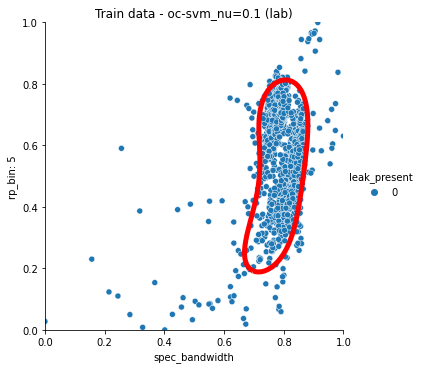

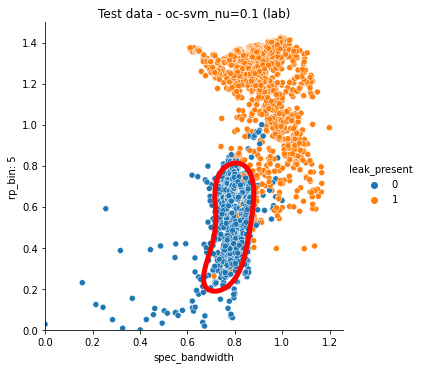

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


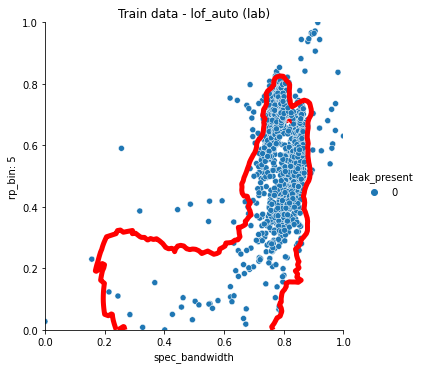

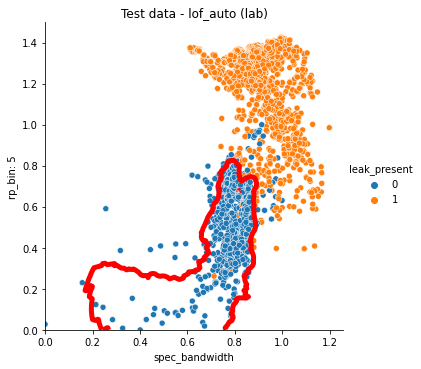

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


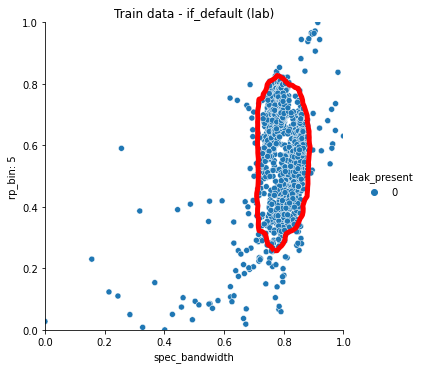

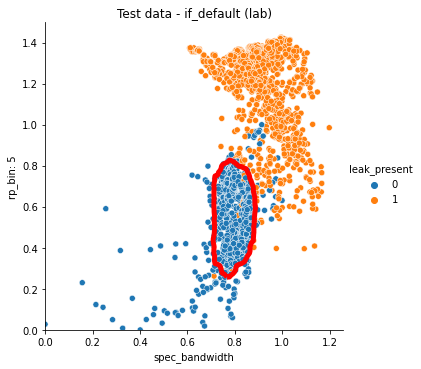

In [ ]:
exploring_env = ["lab", "lab"]
plot_X_train = df_train_features.loc[(df_train_features.leak_present == 0) & (df_train_features['environment'] == exploring_env[0])]
plot_X_test = df_train_features[df_train_features['environment']== exploring_env[0]]

plot_X_train_lp = plot_X_train["leak_present"]
plot_X_test_lp = plot_X_test["leak_present"]

#features = ["spec_bandwidth", "rp_bin: 5"]
#if len(sub_features) == 2:
#  features = sub_features
#else:
features = ["spec_bandwidth", "rp_bin: 5"]

plot_X_train,plot_X_test = preprocesses(plot_X_train[features],plot_X_test[features])

plot_X_train_lp.reset_index(drop=True, inplace=True)
plot_X_train = pd.concat([plot_X_train, plot_X_train_lp], axis=1)

plot_X_test_lp.reset_index(drop=True, inplace=True)
plot_X_test = pd.concat([plot_X_test, plot_X_test_lp], axis=1)

for model in models: 
  plot_model = models[model]
  sns.relplot(data=plot_X_train, x=features[0], y=features[1], hue="leak_present", height=5,  aspect=1)    
  xx1, yy1 = np.meshgrid(np.linspace(0,1, 100), np.linspace(0,1, 100))
  plot_model.fit(plot_X_train[features])
  Z1 = plot_model.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
  Z1 = Z1.reshape(xx1.shape)
  plt.contour(xx1, yy1, Z1, levels=[0], linewidths=5, colors="red")
  plt.title("Train data - " + model + " ("+exploring_env[0]+")")
  plt.show()


  sns.relplot(data=plot_X_test, x=features[0], y=features[1], hue='leak_present', height=5,  aspect=1)
  plt.contour(xx1, yy1, Z1, levels=[0], linewidths=5, colors="red")
  plt.title("Test data - " + model + " ("+exploring_env[0]+")")
  plt.show()

In [ ]:
plot_model = models["lof"]

sns.relplot(data=X_train_info, x="spec_bandwidth", y="rp_bin: 5", hue='leak_present', height=5,  aspect=1)    
xx1, yy1 = np.meshgrid(np.linspace(0,1, 100), np.linspace(0,1, 100))
plot_model.fit(X_train)
Z1 = plot_model.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
Z1 = Z1.reshape(xx1.shape)
plt.contour(xx1, yy1, Z1, levels=[0], linewidths=5, colors="red")
plt.title("Train data")
plt.show()


sns.relplot(data=X_test_info, x="spec_bandwidth", y="rp_bin: 5", hue='leak_present', height=5,  aspect=1)
plt.contour(xx1, yy1, Z1, levels=[0], linewidths=5, colors="red")
plt.title("Test data")
plt.show()

In [ ]:
pd.DataFrame(all_results_Novelty)

In [ ]:
data = all_results_Novelty
#'ventleak', 
#'ventlow',
#'tubeleak'
for key,val in data.items():
  print(key)
  print("_____")
  for model in val: 
    print(model)
    sum = []
    for res, resval in val[model].items(): 
      sum.append(resval[0])
      print(str(resval[0])[0:5],str(resval[1])[0:4] )
    print(str(np.mean(sum))[:5]+ "," + str(statistics.pstdev(sum))[:4])

lab->lab
_____
oc-svm_nu=0.1
85.14 12.3
88.02 6.77
82.90 12.4
85.35,2.09
lof_auto
89.01 12.0
86.00 10.0
86.97 9.73
87.33,1.25
if_default
91.16 4.88
88.82 5.09
88.02 4.71
89.33,1.33
hydr->hydr
_____
oc-svm_nu=0.1
81.34 3.13
81.83 0.99
31.42 5.29
64.87,23.6
lof_auto
88.64 0.19
88.58 2.55
43.37 2.37
73.53,21.3
if_default
81.38 1.49
80.31 0.64
53.12 2.76
71.60,13.0
work->work
_____
oc-svm_nu=0.1
82.43 7.30
83.58 5.17
69.93 8.81
78.65,6.18
lof_auto
89.30 5.08
87.26 4.89
65.31 13.5
80.63,10.8
if_default
82.35 6.97
82.83 4.57
66.33 12.6
77.17,7.66
hydr->hydr_low
_____
oc-svm_nu=0.1
82.87 1.23
74.45 4.37
41.32 2.26
66.21,17.9
lof_auto
76.74 0.72
71.06 1.90
42.60 4.05
63.47,14.9
if_default
69.79 2.01
66.63 1.42
48.30 1.58
61.57,9.47
work->work_low
_____
oc-svm_nu=0.1
77.94 6.38
82.23 11.2
82.07 4.55
80.75,1.98
lof_auto
83.74 7.89
83.45 11.8
83.52 7.54
83.57,0.12
if_default
77.56 5.86
81.13 10.4
81.24 4.71
79.98,1.70
